In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

In [3]:
import os
base_dir = '/content/drive/MyDrive/RBL1/DDD/Prepared_Data/'

print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/train'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/validation'))

Contents of base directory:
['train', 'validation']

Contents of train directory:
['crack', 'uncracked']

Contents of validation directory:
['crack', 'uncracked']


In [4]:
import os

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training cat/dog pictures
train_crack_dir = os.path.join(train_dir, 'crack')
train_uncracked_dir = os.path.join(train_dir, 'uncracked')

# Directory with validation cat/dog pictures
validation_crack_dir = os.path.join(validation_dir, 'crack')
validation_uncracked_dir = os.path.join(validation_dir, 'uncracked')

In [5]:
train_crack_fnames = os.listdir( train_crack_dir )
train_uncracked_fnames = os.listdir( train_uncracked_dir )

print(train_crack_fnames[:10])
print(train_uncracked_fnames[:10])

['074-143.jpg', '086-197.jpg', '092-83.jpg', '069-57.jpg', '063-131.jpg', '074-83.jpg', '082-124.jpg', '067-74.jpg', '073-63.jpg', '078-103.jpg']
['7026-3.jpg', '7028-238.jpg', '7025-190.jpg', '7021-166.jpg', '7028-128.jpg', '7022-215.jpg', '7024-166.jpg', '7023-96.jpg', '7021-36.jpg', '7025-12.jpg']


In [6]:
print('total training crack images :', len(os.listdir(      train_crack_dir ) ))
print('total training uncracked images :', len(os.listdir(      train_uncracked_dir ) ))

print('total validation crack images :', len(os.listdir( validation_crack_dir ) ))
print('total validation uncracked images :', len(os.listdir( validation_uncracked_dir ) ))

total training crack images : 5000
total training uncracked images : 5000
total validation crack images : 2000
total validation uncracked images : 2000


In [7]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

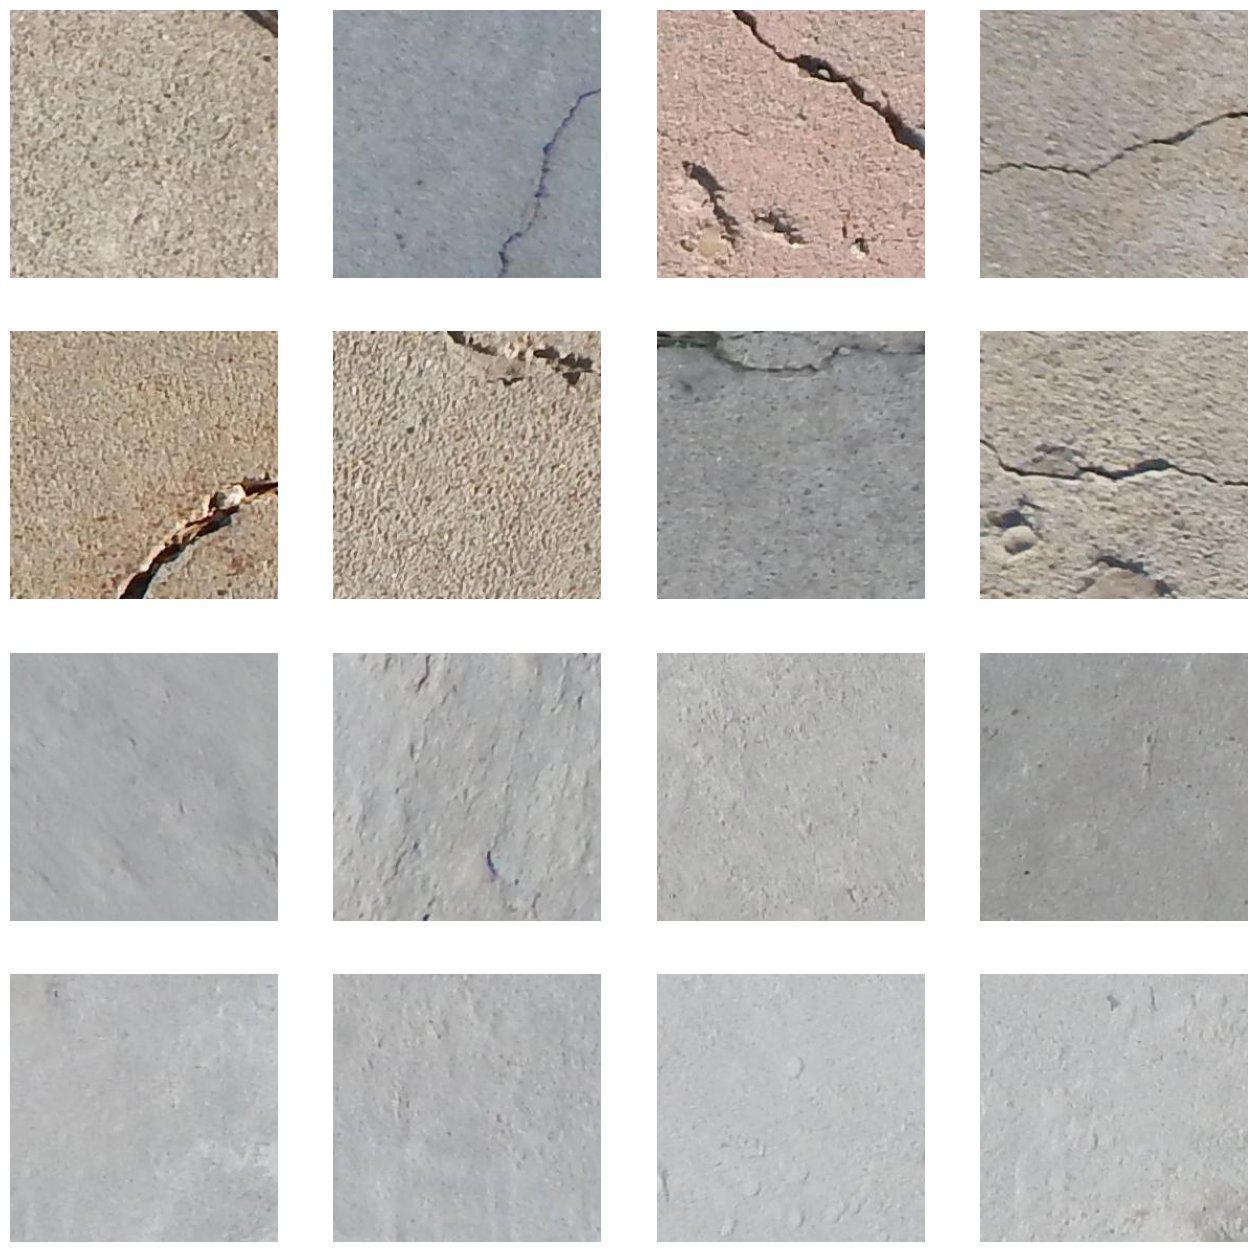

In [8]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_crack_pix = [os.path.join(train_crack_dir, fname) 
                for fname in train_crack_fnames[ pic_index-8:pic_index] 
               ]

next_uncracked_pix = [os.path.join(train_uncracked_dir, fname) 
                for fname in train_uncracked_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_crack_pix+next_uncracked_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [9]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [11]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy', 'mse'])

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 256 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=256,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 256using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=256,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


Found 10000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [13]:
history = model.fit(
            train_generator,
            epochs=20,
            validation_data=validation_generator,
            verbose=2
            )

Epoch 1/20
40/40 - 461s - loss: 0.6147 - accuracy: 0.6766 - mse: 0.2096 - val_loss: 0.1997 - val_accuracy: 0.9355 - val_mse: 0.0539 - 461s/epoch - 12s/step
Epoch 2/20
40/40 - 43s - loss: 0.2701 - accuracy: 0.8991 - mse: 0.0778 - val_loss: 0.6157 - val_accuracy: 0.5000 - val_mse: 0.2400 - 43s/epoch - 1s/step
Epoch 3/20
40/40 - 53s - loss: 0.2345 - accuracy: 0.9073 - mse: 0.0666 - val_loss: 0.0948 - val_accuracy: 0.9780 - val_mse: 0.0214 - 53s/epoch - 1s/step
Epoch 4/20
40/40 - 53s - loss: 0.1915 - accuracy: 0.9327 - mse: 0.0527 - val_loss: 0.0964 - val_accuracy: 0.9825 - val_mse: 0.0207 - 53s/epoch - 1s/step
Epoch 5/20
40/40 - 44s - loss: 0.2050 - accuracy: 0.9181 - mse: 0.0587 - val_loss: 0.0791 - val_accuracy: 0.9780 - val_mse: 0.0183 - 44s/epoch - 1s/step
Epoch 6/20
40/40 - 52s - loss: 0.1787 - accuracy: 0.9305 - mse: 0.0501 - val_loss: 0.0786 - val_accuracy: 0.9790 - val_mse: 0.0176 - 52s/epoch - 1s/step
Epoch 7/20
40/40 - 44s - loss: 0.1717 - accuracy: 0.9399 - mse: 0.0460 - val_lo

Saving 005-31.jpg to 005-31.jpg
1/1 [==============================] - 0s 239ms/step
Label:  [1.1812776e-09]
005-31.jpg is a crack


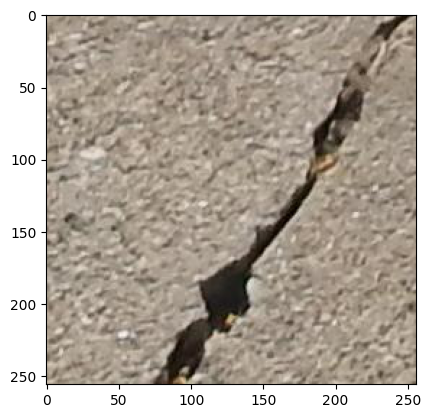

In [14]:
## NOTE: If you are using Safari and this cell throws an error,
## please skip this block and run the next one instead.

import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=load_img(path, target_size=(150, 150))
  
  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print("Label: ",classes[0])
  
  if classes[0]>0.5:
    img = mpimg.imread(fn)
    plt.imshow(img)
    print(fn + " is uncracked")
  else:
    img = mpimg.imread(fn)
    plt.imshow(img)
    print(fn + " is a crack")


1/1 [==============================] - 0s 119ms/step


<ipython-input-15-732a98d09df8>:48: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std ()


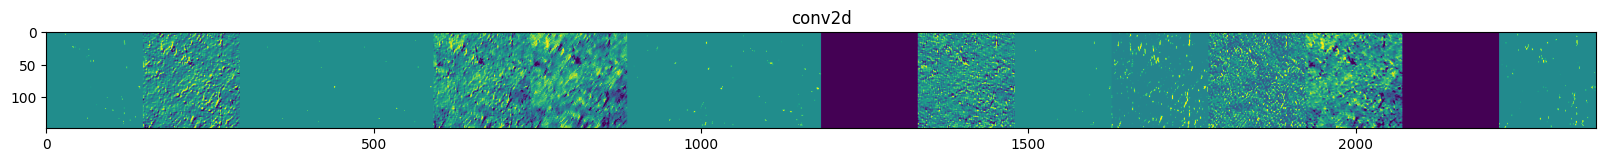

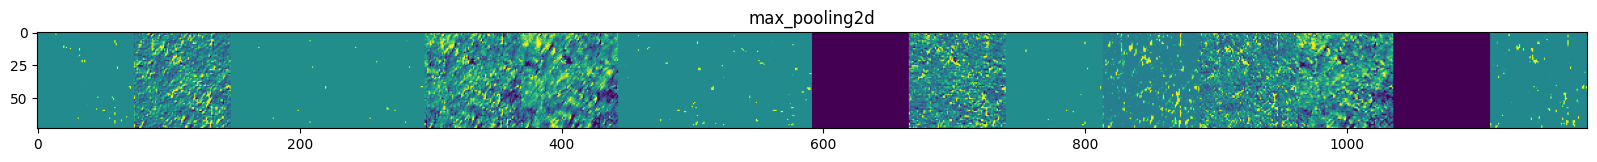

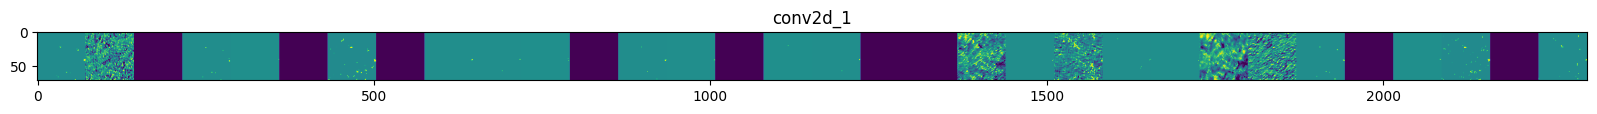

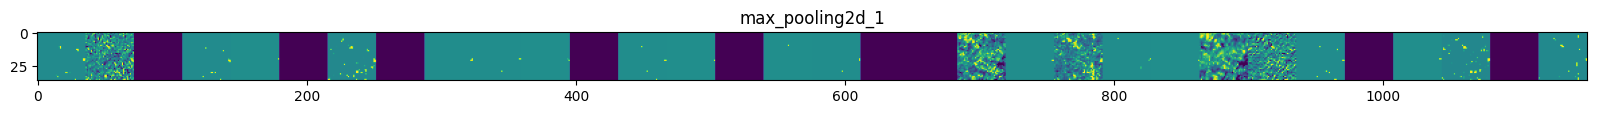

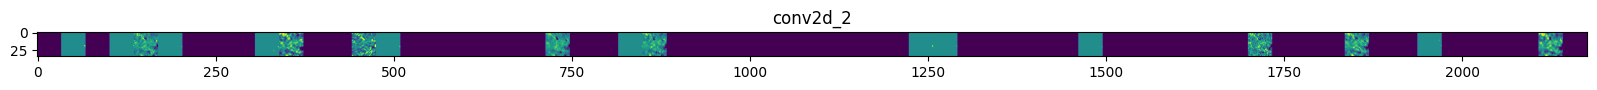

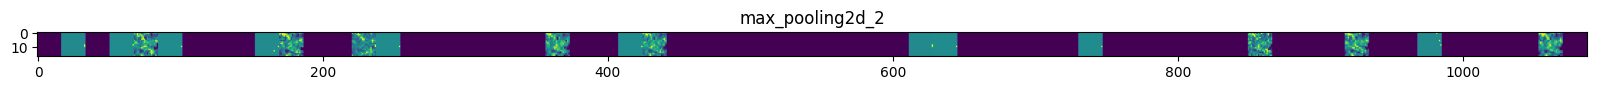

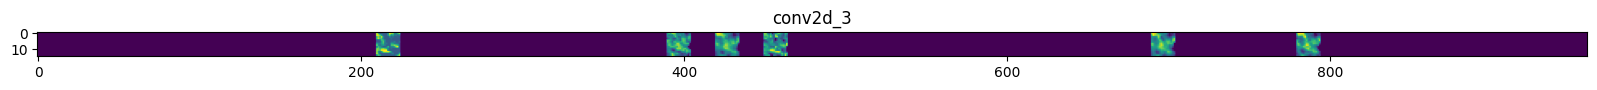

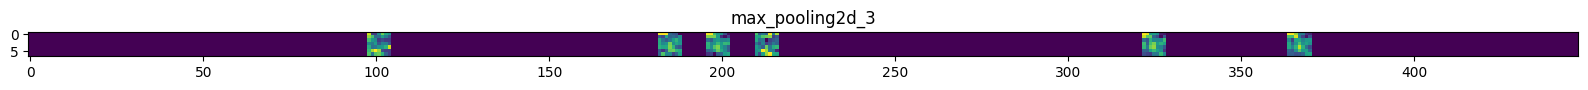

In [15]:
import numpy as np
import random
from tensorflow.keras.utils import img_to_array, load_img

# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
crack_img_files = [os.path.join(train_crack_dir, f) for f in train_crack_fnames]
uncracked_img_files = [os.path.join(train_uncracked_dir, f) for f in train_uncracked_fnames]
img_path = random.choice(crack_img_files + uncracked_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Scale by 1/255
x /= 255.0

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

Text(0.5, 1.0, 'Training and validation loss')

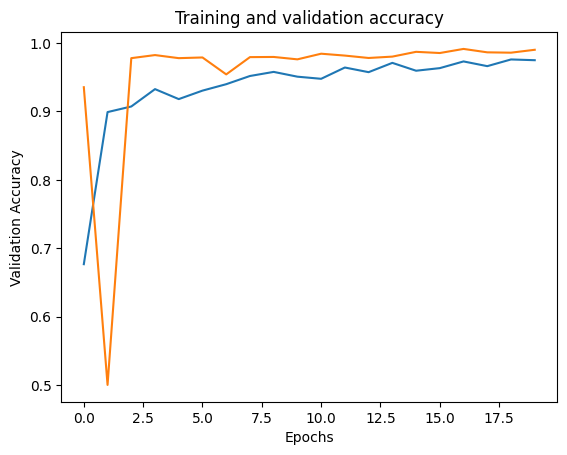

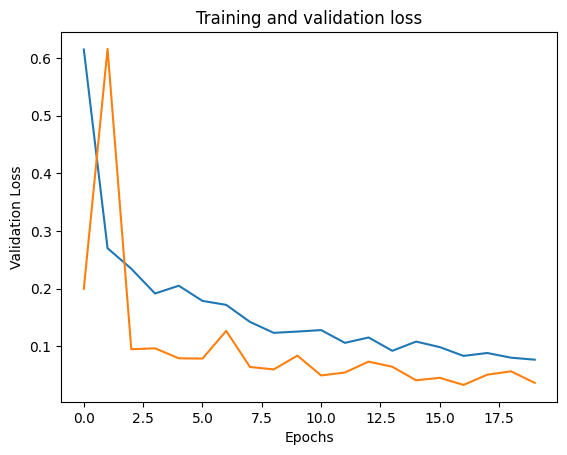

In [17]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title ('Training and validation loss'   )